In [74]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_params

from multi_group_simulation import MultiGroupSimulation

## Importing Params, setting up group sim

In [75]:
ug_dorm_params = load_params('../src/simulations_v2/params/baseline_testing/steady_state/nominal/ug_dorm.yaml')[1]
ug_off_campus_params = load_params('../src/simulations_v2/params/baseline_testing/steady_state/nominal/ug_off_campus.yaml')[1]
gs_research_params = load_params('../src/simulations_v2/params/baseline_testing/steady_state/nominal/grad_research.yaml')[1]
gs_other_params = load_params('../src/simulations_v2/params/baseline_testing/steady_state/nominal/grad_other.yaml')[1]
faculty_staff_student_params = load_params('../src/simulations_v2/params/baseline_testing/steady_state/nominal/faculty_staff_student_same_age.yaml')[1]
faculty_staff_non_student_params = load_params('../src/simulations_v2/params/baseline_testing/steady_state/nominal/faculty_staff_non_student_same_age.yaml')[1]
faculty_staff_off_campus_params = load_params('../src/simulations_v2/params/baseline_testing/steady_state/nominal/faculty_staff_off_campus_same_age.yaml')[1]
ithaca_community_params = load_params('../src/simulations_v2/params/baseline_testing/steady_state/nominal/ithaca_community.yaml')[1]

In [57]:
interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                               [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                               [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                               [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                               [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                               [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                               [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                               [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']

In [58]:
lockdown_matrix_str = \
"""6.25	2	0.05	0.05	0	0	0	0.02
1.70	4	0.05	0.05	0	0	0	0.04
0.09	0.11	2	0.05	0	0	0	0.36
0.07	0.08	0.04	4.5	0	0	0	0.04
0.00	0.00	0.00	0.00	0.5	0.075	0.15	0.78
0.00	0.00	0.00	0.00	0.14	0.9	0.1	0.78
0.00	0.00	0.00	0.00	0.11	0.04	0.9	0.78
0.002	0.005	0.021	0.003	0.045	0.024	0.060	3.5"""

lockdown_matrix = np.array([[float(entry) for entry in line.split('\t')] for line in lockdown_matrix_str.split('\n')])

In [59]:
def get_cum_hosp(df):
    return df[['severity_3', 'severity_2']].iloc[df.shape[0] - 1].sum()

def get_cum_outside_infections(df):
    return df['cumulative_outside_infections'].iloc[df.shape[0] - 1].sum()

def get_cum_infections(df):
    return df[['cumulative_mild', 'cumulative_severe']].iloc[df.shape[0] - 1].sum()

def total_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_infections(sim_df)
    return total

def total_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_hosp(sim_df)
    return total

def cornell_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs[:-1]:
        total += get_cum_infections(sim_df)
    return total

def cornell_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs[:-1]:
        total += get_cum_hosp(sim_df)
    return total

In [82]:
def run_multigroup_sim(sim, T):
    lockdown_statuses, sim_df = sim.run_new_trajectory(12*7)
    popsize = sim.get_total_population()
    infection_counts = sim_df[['S', 'QS']].apply(lambda x: (popsize - sum(x)) / popsize * 100, axis=1)
    inf_list = list()
    hosp_list = list()
    for group in sim.sims:
        df = group.sim_df
        inf_list.append(get_cum_infections(df))
        hosp_list.append(get_cum_hosp(df))
    return inf_list, hosp_list, lockdown_statuses, list(infection_counts)

def run_multiple_trajectories(sim, T, n):
    inf_matrix = list()
    hosp_matrix = list()
    lockdown_trajectories = []
    infection_trajectories = []
    for _ in range(n):
        inf, hosp, lockdowns, infections = run_multigroup_sim(sim, T)
        inf_matrix.append(inf)
        hosp_matrix.append(hosp)
        lockdown_trajectories.append(lockdowns)
        infection_trajectories.append(infections)
    return inf_matrix, hosp_matrix, lockdown_trajectories, infection_trajectories

In [119]:
sim = MultiGroupSimulation(get_params_list_copy(), interaction_matrix, group_names)
popsize = sim.get_total_population()

In [62]:
def evaluate_testing_policy_v2(params_list, interaction_matrix, group_names, test_frac, T, n,
                           post_lockdown_matrix, new_cases_threshold, new_cases_time_window):
    assert len(params_list) == len(test_frac)
    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)

    sim.configure_lockdown(post_lockdown_matrix, [True] * 7 + [False], new_cases_threshold, new_cases_time_window)
    
    inf_matrix, hosp_matrix, lockdown_trajectories, infection_trajectories = run_multiple_trajectories(sim, T, n)
    
    return lockdown_trajectories, infection_trajectories

In [63]:
import copy

def get_interaction_matrix(contact_multiplier):
    new_interaction_matrix = copy.copy(interaction_matrix)
    ithaca_group_id = 7
    for i in range(interaction_matrix.shape[0]):
        for j in range(interaction_matrix.shape[1]):
            if i != ithaca_group_id and j != ithaca_group_id:
                new_interaction_matrix[i,j] = contact_multiplier * new_interaction_matrix[i,j]
    return new_interaction_matrix
            

In [83]:
def simulate_lockdown_v2(contact_multiplier, infections_thresh, infections_window, nreps=10):
    simulation_population = 90890
    new_cases_thresh = infections_thresh / simulation_population
    test_policy = [2/7,2/7,1/7,2/7,2/7,1/7,1/30,0]
    
    return evaluate_testing_policy_v2(get_params_list_copy(),
                                      get_interaction_matrix(contact_multiplier),
                                      group_names,
                                      test_policy,
                                      12*7,
                                      nreps,
                                      lockdown_matrix,
                                       new_cases_thresh,
                                       infections_window)

In [65]:
def get_params_list_copy():
    return [ug_dorm_params.copy(), 
            ug_off_campus_params.copy(), 
            gs_research_params.copy(), 
            gs_other_params.copy(), 
            faculty_staff_student_params.copy(), 
            faculty_staff_non_student_params.copy(), 
            faculty_staff_off_campus_params.copy(), 
            ithaca_community_params.copy()]

In [66]:
import multiprocessing, time

def run_sim_wrapper(contact_multiplier, infections_thresh, infections_window,
                    proc_key, nreps, return_dict):
    lockdowns, final_infections = simulate_lockdown_v2(contact_multiplier, 
                                                    infections_thresh, 
                                                    infections_window,
                                                    nreps=nreps)
    return_dict[proc_key] = {'lockdown_pct': lockdowns,
                            'final_infection_pct': final_infections}


    
def simulate_protocol_multiprocessing(infections_thresh, infections_window, nreps):
    manager = multiprocessing.Manager()
    return_dict = manager.dict()

    jobs = []


    for mult in [1,1.2,1.4,1.6,1.8,2, 2.2, 2.4, 2.6, 2.8, 3]:
        p = multiprocessing.Process(target = run_sim_wrapper,
                                   args = (mult, infections_thresh, infections_window, mult, nreps, return_dict))
        jobs.append(p)
        p.start()

    for p in jobs:
        p.join()
    
    return return_dict


In [84]:
nreps = 100
return_dicts = {}
infection_thresholds = [150,200,250,300,350]
infection_windows = [7]

import itertools

for thresh, window in itertools.product(infection_thresholds, infection_windows):
    start = time.time()
    return_dict = simulate_protocol_multiprocessing(thresh, window, nreps)
    end = time.time()
    return_dicts[(thresh, window)] = {key:val for key,val in return_dict.items()}
    print("done simulating {} in {:.2f} seconds".format((thresh, window), end-start))


done simulating (150, 7) in 570.95 seconds
done simulating (200, 7) in 571.64 seconds
done simulating (250, 7) in 529.26 seconds
done simulating (300, 7) in 532.70 seconds
done simulating (350, 7) in 529.04 seconds


In [ ]:
return_dicts

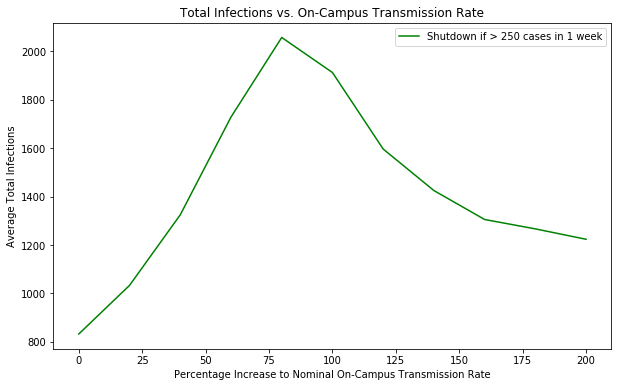

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))

mults = [1,1.2,1.4,1.6,1.8,2, 2.2, 2.4, 2.6, 2.8, 3]

keys = list(return_dicts.keys())

xlabel_mults = [(mult-1)*100 for mult in mults]

for key in keys:
    if key[0] != 250:
        continue
    return_dict = return_dicts[key]
    infections = []
    for mult in mults:
        infections.append(np.mean([inf[-1] / 100 * popsize for inf in return_dict[mult]['final_infection_pct']]))
    plt.plot(xlabel_mults, infections, label="Shutdown if > {} cases in 1 week".format(key[0]), color='green')

plt.xlabel("Percentage Increase to Nominal On-Campus Transmission Rate")
plt.ylabel("Average Total Infections")
plt.title("Total Infections vs. On-Campus Transmission Rate")
plt.legend(loc='best')

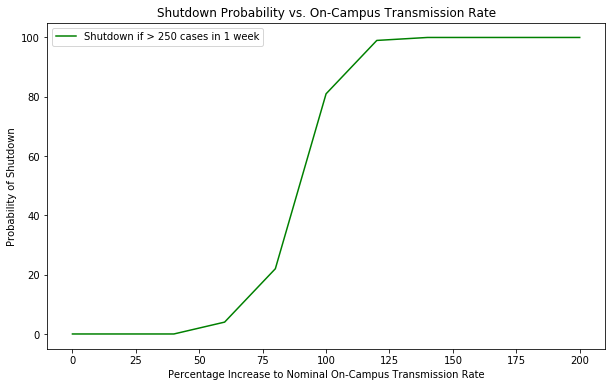

In [106]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))

mults = [1,1.2,1.4,1.6,1.8,2, 2.2, 2.4, 2.6, 2.8, 3]
for key in keys:
    if key[0] != 250: 
        continue
    return_dict = return_dicts[key]
    lockdowns = []
    for mult in mults:
        lockdowns.append(np.mean([pct[-1] for pct in return_dict[mult]['lockdown_pct']]) * 100)
    plt.plot(xlabel_mults, lockdowns, label="Shutdown if > {} cases in 1 week".format(key[0]), color='green')

plt.xlabel("Percentage Increase to Nominal On-Campus Transmission Rate")
plt.ylabel("Probability of Shutdown")
plt.title("Shutdown Probability vs. On-Campus Transmission Rate")
plt.legend(loc='best')

In [122]:
return_dict[mult]['final_infection_pct'][-1]

[0.10342171856089778,
 0.11992518428870062,
 0.13532841896798328,
 0.15623280888986688,
 0.16833535042358894,
 0.18923974034547256,
 0.20794366817031576,
 0.22994828914071958,
 0.26075475849928487,
 0.29046099680932996,
 0.33116954560457695,
 0.3619760149631423,
 0.3927824843217076,
 0.4356914952139949,
 0.48850258554296405,
 0.5380129827263725,
 0.5831224557157003,
 0.6337330839476291,
 0.6788425569369568,
 0.7525580371878094,
 0.8284739795357025,
 0.8922873803498734,
 0.9572010122125647,
 1.0364176477060183,
 1.1255363626361536,
 1.22125646385741,
 1.3125756408845857,
 1.3972934316206405,
 1.5139179227637805,
 1.5458246231708659,
 1.575530861480911,
 1.6019364066453954,
 1.6151391792276377,
 1.6327428760039608,
 1.6437451864891626,
 1.6525470348773244,
 1.6701507316536472,
 1.6800528110903288,
 1.68555396633293,
 1.6932555836725711,
 1.6976565078666521,
 1.7009572010122125,
 1.704257894157773,
 1.708658818351854,
 1.709759049400374,
 1.7119595114974147,
 1.7163604356914952,
 1.719661

In [123]:
[inf[-1] / 100 * popsize for inf in return_dict[mult]['final_infection_pct']]

[1537.0,
 1719.9999999999998,
 1792.0,
 1552.0,
 1773.0000000000002,
 2112.0,
 1545.0,
 1996.0000000000002,
 1704.0,
 1713.9999999999998,
 2077.9999999999995,
 1814.9999999999998,
 1757.0,
 1648.0000000000002,
 1826.0,
 1621.0,
 1603.9999999999998,
 1645.0000000000002,
 2240.0,
 1654.0000000000002,
 1567.0,
 1849.0,
 1848.0,
 1663.0000000000002,
 1630.0,
 1912.0,
 1483.0,
 1927.9999999999998,
 1719.0,
 1771.0,
 1713.0,
 1605.0,
 2040.0,
 1632.0,
 1882.0,
 1724.0,
 1706.0,
 1760.0,
 1980.0,
 1901.9999999999995,
 1700.0,
 1695.9999999999998,
 1890.0,
 1813.0,
 1643.0,
 1968.0,
 1716.9999999999998,
 1783.0,
 2030.0,
 1816.0,
 1742.0,
 1585.0,
 1528.0,
 2083.0000000000005,
 1752.0000000000002,
 1520.0,
 1847.0,
 1715.0,
 1813.0,
 2001.0,
 1859.0000000000002,
 1843.0,
 1764.0000000000002,
 1859.0000000000002,
 1768.0,
 1624.0,
 1793.0,
 1681.0000000000002,
 1975.9999999999995,
 1896.0000000000002,
 1579.9999999999998,
 1895.0000000000005,
 1909.9999999999998,
 1749.0000000000002,
 1748.0,
 

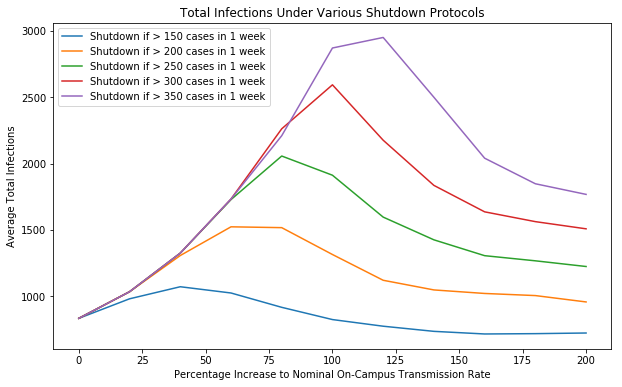

In [125]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))

mults = [1,1.2,1.4,1.6,1.8,2, 2.2, 2.4, 2.6, 2.8, 3]

keys = list(return_dicts.keys())

xlabel_mults = [(mult-1)*100 for mult in mults]

for key in keys:
    if key[0] == 400:
        continue
    return_dict = return_dicts[key]
    infections = []
    for mult in mults:
        infections.append(np.mean([inf[-1] / 100 * popsize for inf in return_dict[mult]['final_infection_pct']]))
    plt.plot(xlabel_mults, infections, label="Shutdown if > {} cases in 1 week".format(key[0]))

plt.xlabel("Percentage Increase to Nominal On-Campus Transmission Rate")
plt.ylabel("Average Total Infections")
plt.title("Total Infections Under Various Shutdown Protocols")
plt.legend(loc='best')

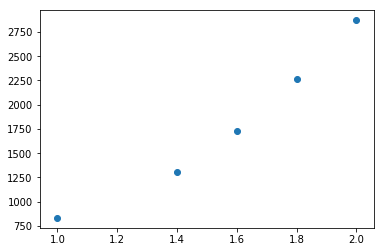

In [127]:
def get_max_R0_increase(shutdown_policy, max_p_shutdown = 0.05):
    return_dict = return_dicts[shutdown_policy]
    max_increase = -1
    mults = [1,1.2,1.4,1.6,1.8,2, 2.2, 2.4, 2.6, 2.8, 3]
    for mult in mults:
        #print (np.mean([pct[-1] for pct in return_dict[mult]['lockdown_pct']]))
        if np.mean([pct[-1] for pct in return_dict[mult]['lockdown_pct']]) <= max_p_shutdown:
            max_increase = mult
            
    infections = np.mean([inf[-1] / 100 * popsize for inf in return_dict[max_increase]['final_infection_pct']])
    
    return max_increase, infections



max_increases = []
all_infections = []
for key in return_dicts.keys():
    
    max_increase, infections = get_max_R0_increase(key)
    
    max_increases.append(max_increase)
    
    all_infections.append(infections)

plt.scatter(max_increases, all_infections)

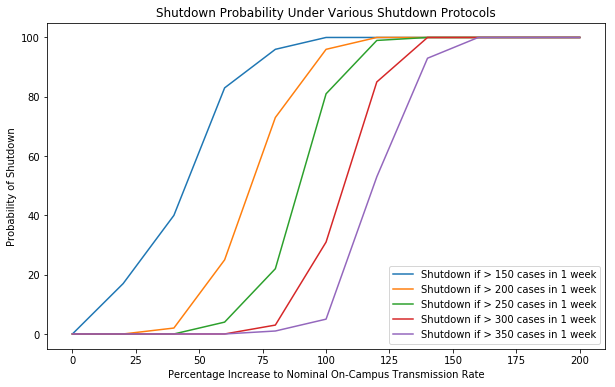

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))

mults = [1,1.2,1.4,1.6,1.8,2, 2.2, 2.4, 2.6, 2.8, 3]
for key in keys:
    if key[0] == 400: 
        continue
    return_dict = return_dicts[key]
    lockdowns = []
    for mult in mults:
        lockdowns.append(np.mean([pct[-1] for pct in return_dict[mult]['lockdown_pct']]) * 100)
    plt.plot(xlabel_mults, lockdowns, label="Shutdown if > {} cases in 1 week".format(key[0]))

plt.xlabel("Percentage Increase to Nominal On-Campus Transmission Rate")
plt.ylabel("Probability of Shutdown")
plt.title("Shutdown Probability Under Various Shutdown Protocols")
plt.legend(loc='best')

In [109]:
return_dicts.keys()

dict_keys([(150, 7), (200, 7), (250, 7), (300, 7), (350, 7)])

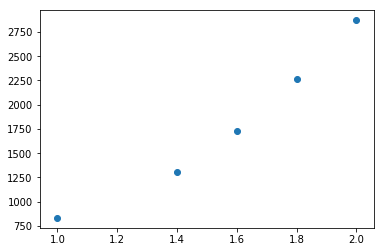

In [126]:
def get_max_R0_increase(shutdown_policy, max_p_shutdown = 0.05):
    return_dict = return_dicts[shutdown_policy]
    max_increase = -1
    mults = [1,1.2,1.4,1.6,1.8,2, 2.2, 2.4, 2.6, 2.8, 3]
    for mult in mults:
        #print (np.mean([pct[-1] for pct in return_dict[mult]['lockdown_pct']]))
        if np.mean([pct[-1] for pct in return_dict[mult]['lockdown_pct']]) <= max_p_shutdown:
            max_increase = mult
            
    infections = np.mean([inf[-1] / 100 * popsize for inf in return_dict[max_increase]['final_infection_pct']])
    
    return max_increase, infections



max_increases = []
all_infections = []
for key in return_dicts.keys():
    
    max_increase, infections = get_max_R0_increase(key)
    
    max_increases.append(max_increase)
    
    all_infections.append(infections)

plt.scatter(max_increases, all_infections)

In [116]:
np.mean([inf[-1]  for inf in return_dict[mult]['final_infection_pct']]) * 960

1866.6079876774124

In [115]:
len(return_dict[mult]['final_infection_pct'])

100

In [30]:
infection_thresholds = [150]
infection_windows = [7]

import itertools

for thresh, window in itertools.product(infection_thresholds, infection_windows):
    start = time.time()
    return_dict = simulate_protocol_multiprocessing(thresh, window, nreps)
    end = time.time()
    return_dicts[(thresh, window)] = {key:val for key,val in return_dict.items()}
    print("done simulating {} in {:.2f} seconds".format((thresh, window), end-start))

done simulating (150, 7) in 176.44 seconds


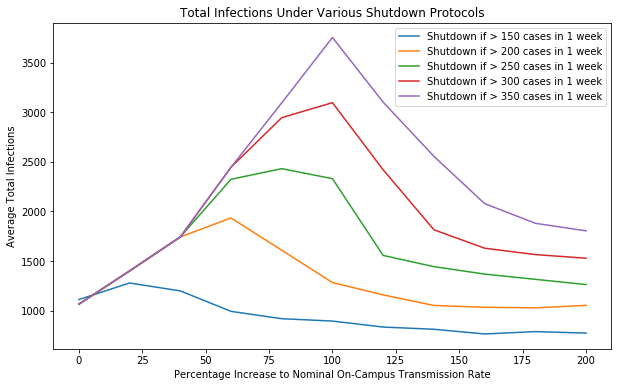

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))

mults = [1,1.2,1.4,1.6,1.8,2, 2.2, 2.4, 2.6, 2.8, 3]

keys = sorted(list(return_dicts.keys()))

xlabel_mults = [(mult-1)*100 for mult in mults]

for key in keys:
    if key[0] == 400:
        continue
    return_dict = return_dicts[key]
    infections = []
    for mult in mults:
        infections.append(np.mean([inf[-1] for inf in return_dict[mult]['final_infection_pct']]) * 960)
    plt.plot(xlabel_mults, infections, label="Shutdown if > {} cases in 1 week".format(key[0]))

plt.xlabel("Percentage Increase to Nominal On-Campus Transmission Rate")
plt.ylabel("Average Total Infections")
plt.title("Total Infections Under Various Shutdown Protocols")
plt.legend(loc='best')

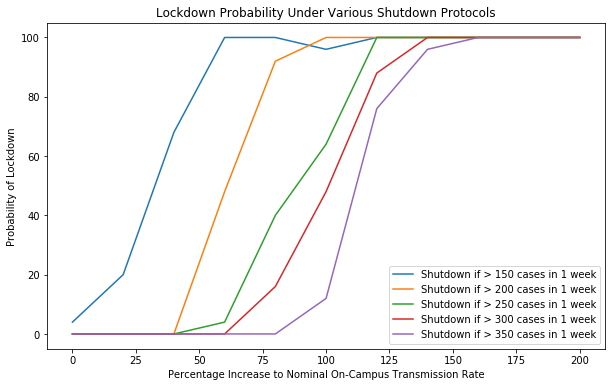

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))

mults = [1,1.2,1.4,1.6,1.8,2, 2.2, 2.4, 2.6, 2.8, 3]
for key in keys:
    if key[0] == 400: 
        continue
    return_dict = return_dicts[key]
    lockdowns = []
    for mult in mults:
        lockdowns.append(np.mean([pct[-1] for pct in return_dict[mult]['lockdown_pct']]) * 100)
    plt.plot(xlabel_mults, lockdowns, label="Shutdown if > {} cases in 1 week".format(key[0]))

plt.xlabel("Percentage Increase to Nominal On-Campus Transmission Rate")
plt.ylabel("Probability of Lockdown")
plt.title("Lockdown Probability Under Various Shutdown Protocols")
plt.legend(loc='best')

In [35]:
return_dicts[(250,7)][1].keys()

dict_keys(['lockdown_pct', 'final_infection_pct'])

In [38]:
return_dicts[key][1]['lockdown_pct']

[[False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
 

In [98]:
np.mean([ell[-1] for ell in return_dict[1.2]['lockdown_pct']])

0.0

In [99]:
np.mean([ell[-1] for ell in return_dict[1.6]['lockdown_pct']])

0.04

In [100]:
np.mean([ell[-1] for ell in return_dict[2.0]['lockdown_pct']])

0.81

In [101]:
np.mean([ell[-1] for ell in return_dict[2.4]['lockdown_pct']])

1.0

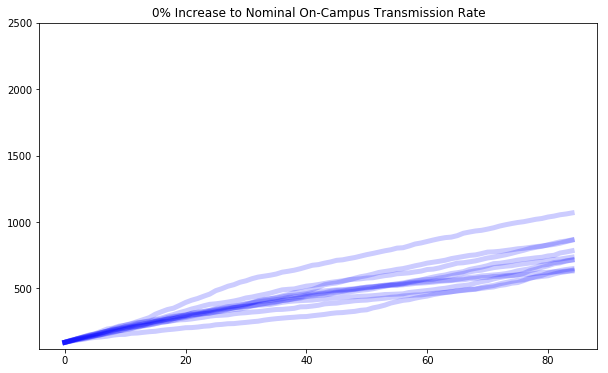

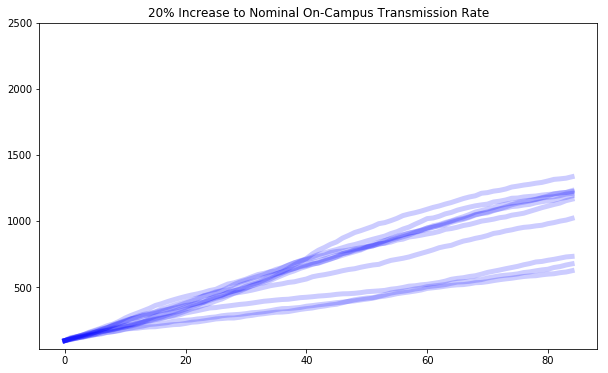

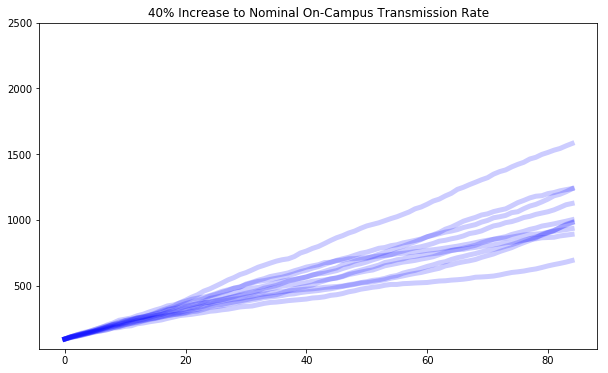

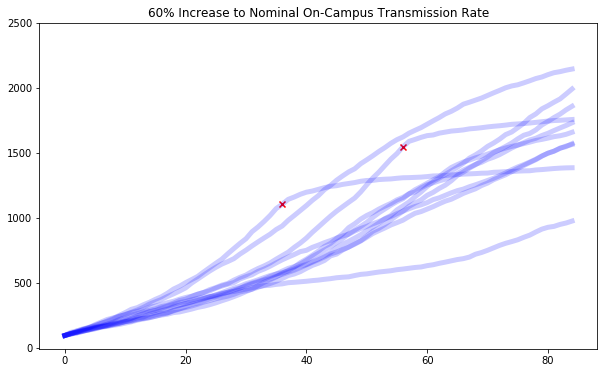

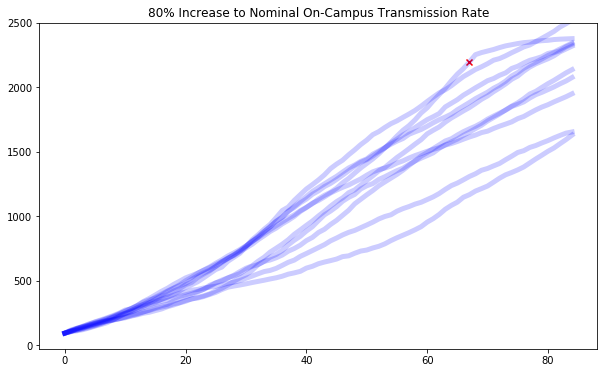

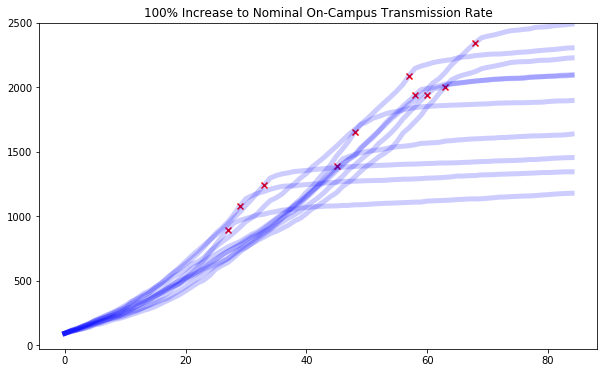

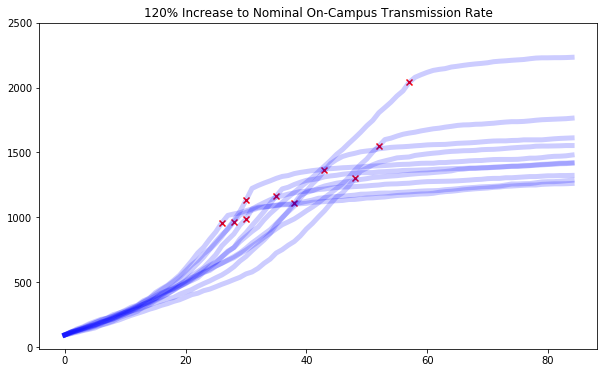

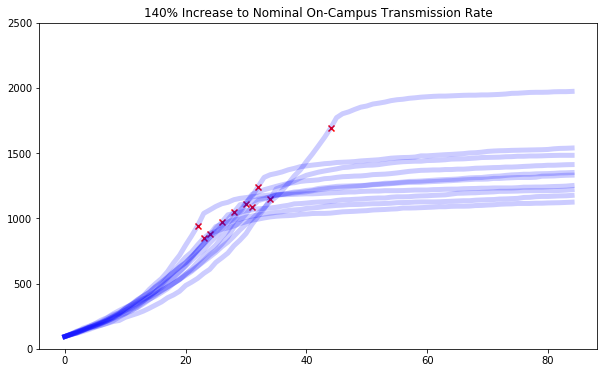

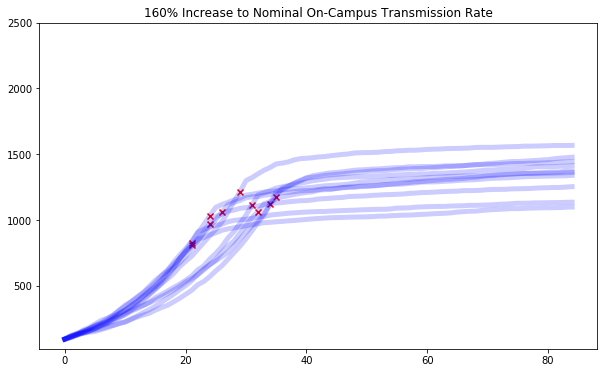

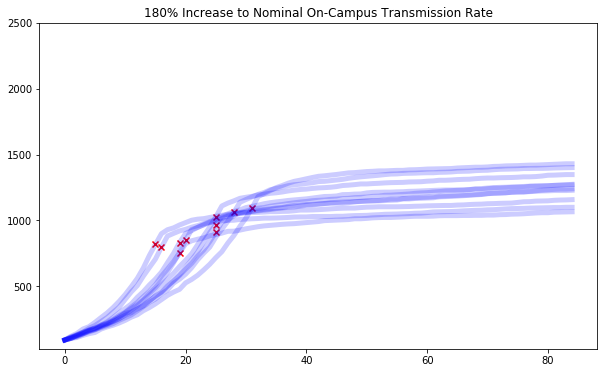

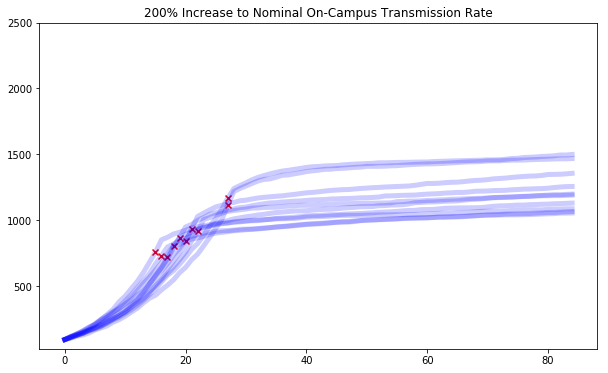

In [94]:
key = (250, 7)
y_max = 2500
return_dict = return_dicts[key]

mults = sorted(list(return_dict.keys()))

for mult in mults:
    plt.figure(figsize=(10,6))
    trajectories = 0
    for ell, i in zip(return_dict[mult]['lockdown_pct'], return_dict[mult]['final_infection_pct']):
        plt.plot([inf  * 90890 / 100 for inf in i], color='blue', alpha=0.2, linewidth=5)
        include_shutdown = False
        for day in range(len(ell)):
            if ell[day]:
                include_shutdown = True
                shutdown_day = day
                shutdown_infections = i[day] * 90890 / 100
                break
    
        if include_shutdown:
            plt.scatter([shutdown_day], [shutdown_infections], color='red', marker='x')
        
        trajectories += 1
        if trajectories >= 10:
            break
    plt.ylim(top=y_max)
    plt.title("{:.0f}% Increase to Nominal On-Campus Transmission Rate".format(((mult-1)*100), key))

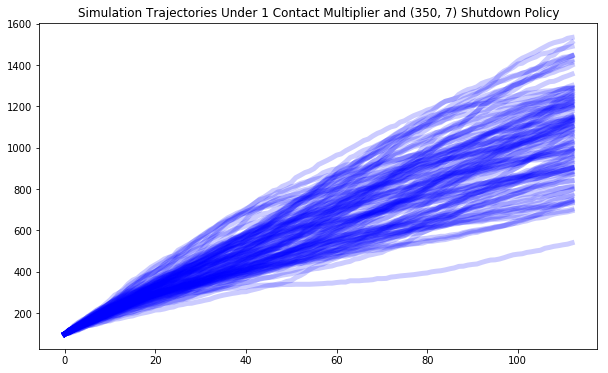

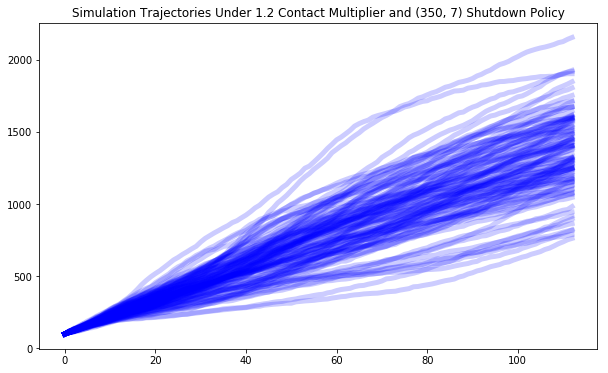

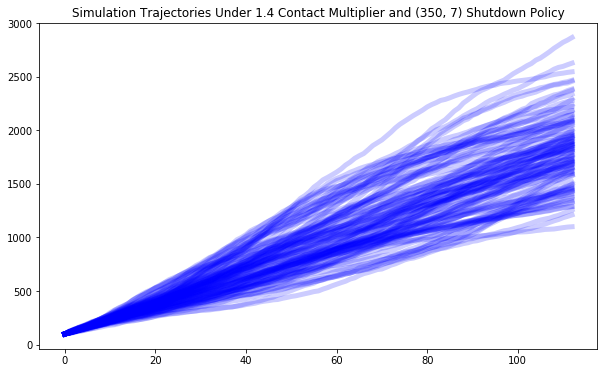

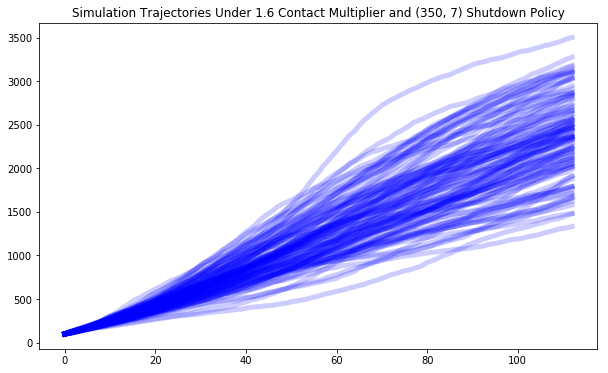

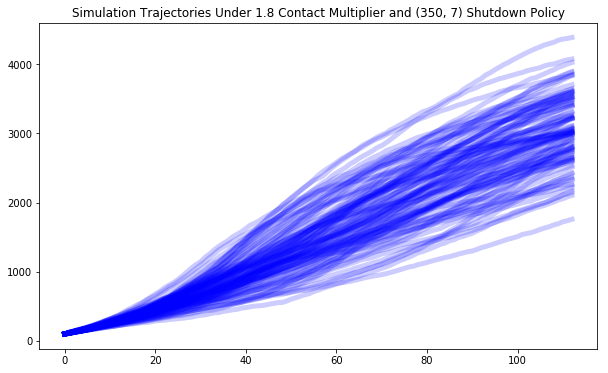

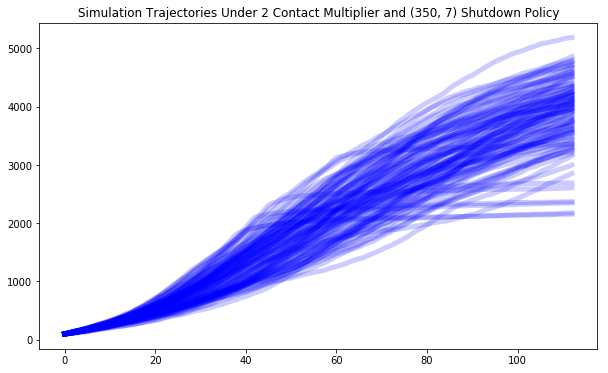

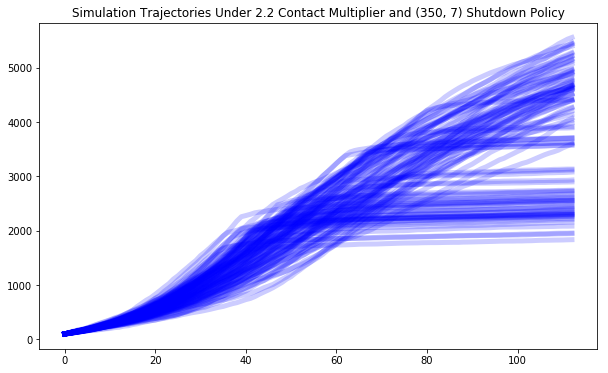

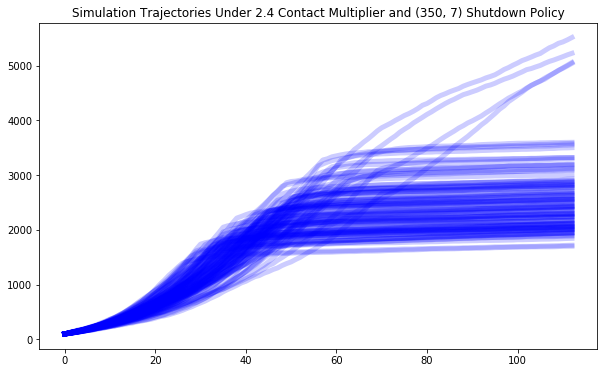

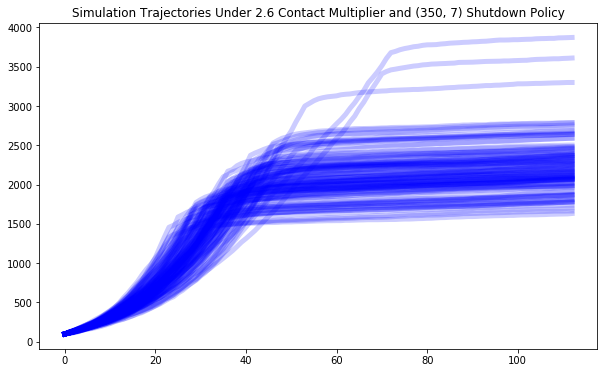

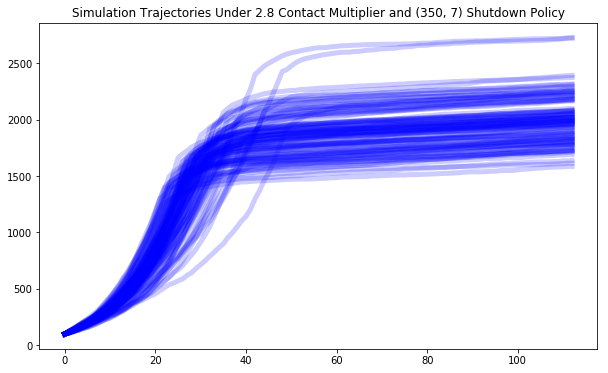

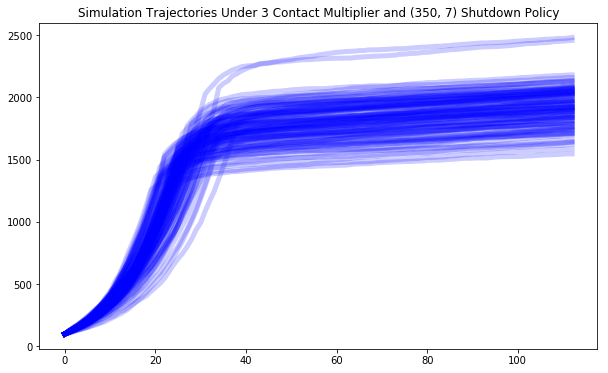

In [72]:
key = (350, 7)
return_dict = return_dicts[key]

mults = sorted(list(return_dict.keys()))

for mult in mults:
    plt.figure(figsize=(10,6))
    
    for i in return_dict[mult]['final_infection_pct']:
        plt.plot([inf  * 95892 / 100 for inf in i], color='blue', alpha=0.2, linewidth=5)
    plt.title("Simulation Trajectories Under {} Contact Multiplier and {} Shutdown Policy".format(mult, key))

In [48]:
lockdowns = {}
infections = {}
for mult in [1, 1.25, 1.5, 1.75, 2]:
    lockdowns[mult], infections[mult] = simulate_lockdown_v2(mult, 200, 7)

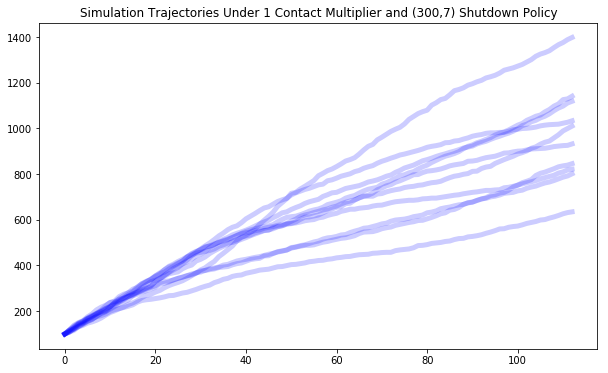

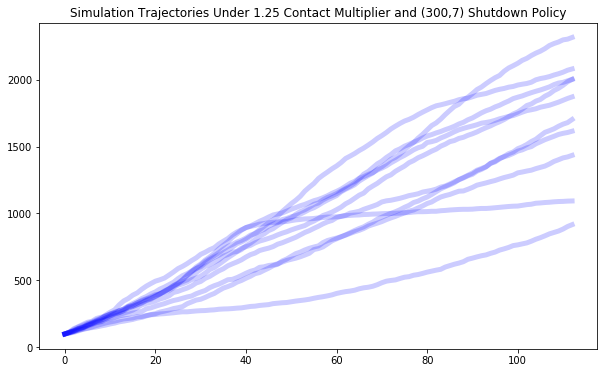

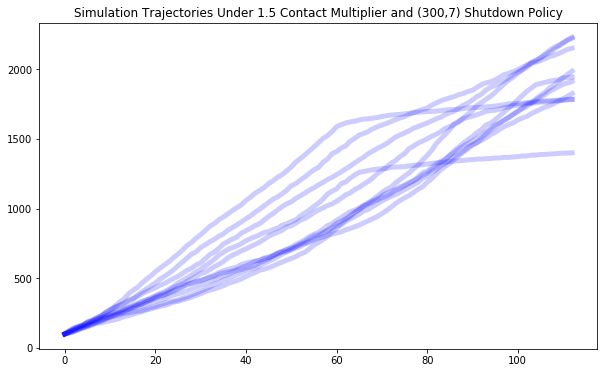

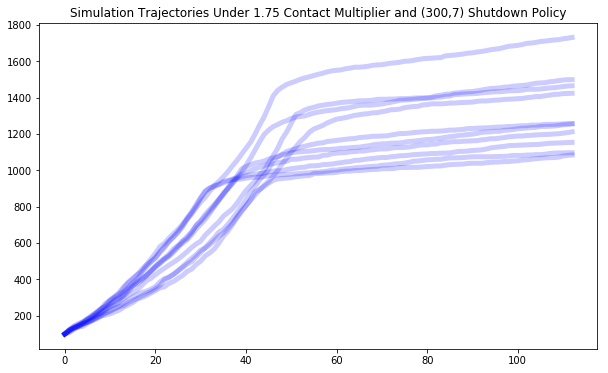

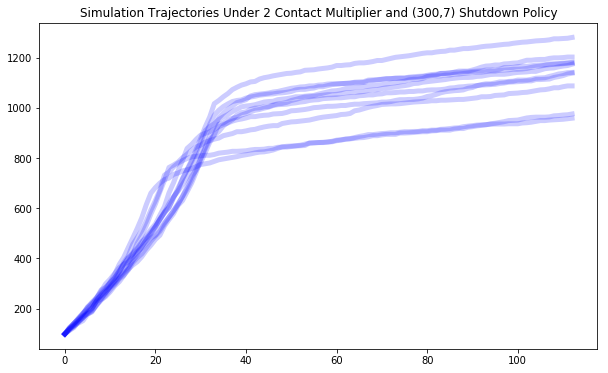

In [49]:
for mult in infections:
    plt.figure(figsize=(10,6))
    for i in infections[mult]:
        plt.plot([inf  * 95892 / 100 for inf in i], color='blue', alpha=0.2, linewidth=5)
    plt.title("Simulation Trajectories Under {} Contact Multiplier and (300,7) Shutdown Policy".format(mult))

In [19]:
def evaluate_testing_policy(params_list, interaction_matrix, group_names, test_frac, T, n,
                           post_lockdown_matrix, new_cases_threshold, new_cases_time_window):
    assert len(params_list) == len(test_frac)
    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)

    sim.configure_lockdown(post_lockdown_matrix, new_cases_threshold, new_cases_time_window)
    
    inf_matrix, hosp_matrix, lockdown_trajectories, infection_trajectories = run_multiple_trajectories(sim, T, n)
    
    return [any(lockdowns) for lockdowns in lockdown_trajectories], [infs[-1] for infs in infection_trajectories]

Note total population is 95892

In [81]:
def simulate_lockdown(contact_multiplier, infections_thresh, infections_window, nreps=10):
    simulation_population = 90890
    new_cases_thresh = infections_thresh / simulation_population
    test_policy = [2/7,2/7,1/7,2/7,2/7,1/7,1/30,0]
    
    return evaluate_testing_policy(get_params_list_copy(),
                                      interaction_matrix * contact_multiplier,
                                      group_names,
                                      test_policy,
                                      12*7,
                                      nreps,
                                      lockdown_matrix,
                                       new_cases_thresh,
                                       infections_window)

In [22]:
import multiprocessing, time

def run_sim_wrapper(contact_multiplier, infections_thresh, infections_window,
                    proc_key, nreps, return_dict):
    lockdowns, final_infections = simulate_lockdown(contact_multiplier, 
                                                    infections_thresh, 
                                                    infections_window,
                                                    nreps=nreps)
    return_dict[proc_key] = {'lockdown_pct': lockdowns,
                            'final_infection_pct': final_infections}



In [23]:
def simulate_protocol_multiprocessing(infections_thresh, infections_window, nreps):
    manager = multiprocessing.Manager()
    return_dict = manager.dict()

    jobs = []


    for mult in [1,1.2,1.4,1.6,1.8,2, 2.2, 2.4, 2.6, 2.8, 3]:
        p = multiprocessing.Process(target = run_sim_wrapper,
                                   args = (mult, infections_thresh, infections_window, mult, nreps, return_dict))
        jobs.append(p)
        p.start()

    for p in jobs:
        p.join()
    
    return return_dict


In [25]:
nreps = 50
return_dicts = {}
infection_thresholds = [100, 300, 500]
infection_windows = [7,10]

import itertools

for thresh, window in itertools.product(infection_thresholds, infection_windows):
    start = time.time()
    return_dict = simulate_protocol_multiprocessing(thresh, window, nreps)
    end = time.time()
    return_dicts[(thresh, window)] = {key:val for key,val in return_dict.items()}
    print("done simulating {} in {:.2f} seconds".format((thresh, window), end-start))


done simulating (100, 7) in 351.77 seconds
done simulating (100, 10) in 350.38 seconds
done simulating (300, 7) in 350.08 seconds
done simulating (300, 10) in 348.75 seconds
done simulating (500, 7) in 350.52 seconds
done simulating (500, 10) in 347.77 seconds


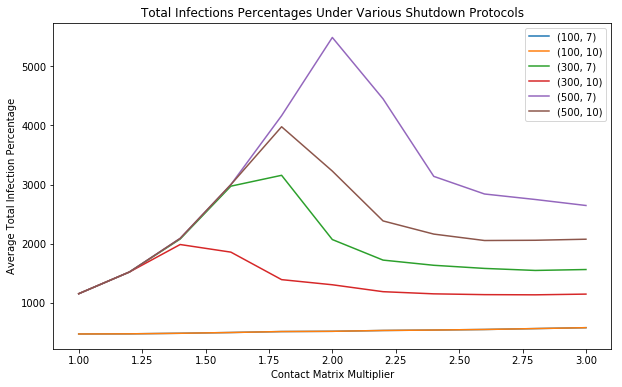

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))

mults = [1,1.2,1.4,1.6,1.8,2, 2.2, 2.4, 2.6, 2.8, 3]
for key in return_dicts:
    return_dict = return_dicts[key]
    infections = []
    for mult in mults:
        infections.append(np.mean(return_dict[mult]['final_infection_pct']) * 960)
    plt.plot(mults, infections, label=key)

plt.xlabel("Contact Matrix Multiplier")
plt.ylabel("Average Total Infection Percentage")
plt.title("Total Infections Percentages Under Various Shutdown Protocols")
plt.legend(loc='best')

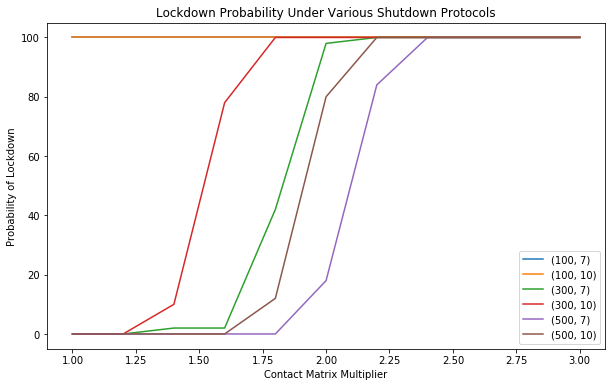

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))

mults = [1,1.2,1.4,1.6,1.8,2, 2.2, 2.4, 2.6, 2.8, 3]
for key in return_dicts:
    return_dict = return_dicts[key]
    lockdowns = []
    for mult in mults:
        lockdowns.append(np.mean(return_dict[mult]['lockdown_pct']) * 100)
    plt.plot(mults, lockdowns, label=key)

plt.xlabel("Contact Matrix Multiplier")
plt.ylabel("Probability of Lockdown")
plt.title("Lockdown Probability Under Various Shutdown Protocols")
plt.legend(loc='best')

In [28]:
return_dicts.keys()

dict_keys([(100, 7), (100, 10), (300, 7), (300, 10), (500, 7), (500, 10)])

In [29]:
return_dicts[(300,7)].keys()

dict_keys([2, 1.4, 1.8, 2.6, 2.4, 3, 1.6, 2.8, 1.2, 1, 2.2])

In [31]:
return_dicts[(300,7)][1]['lockdown_pct']

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [ ]:
nreps = 10
return_dicts = {}
infection_thresholds = [1000]#[100, 500, 1000, 2000]
infection_windows = [7]# [7,14,21]

import itertools

for thresh, window in itertools.product(infection_thresholds, infection_windows):
    start = time.time()
    return_dict = simulate_protocol_multiprocessing(infections_thresh, infections_window, nreps)
    end = time.time()
    return_dicts[(thresh, window)] = {key:val for key,val in return_dict.items()}
    print("done simulating {} in {:.2f} seconds".format((thresh, window), end-start))


In [18]:
return_dict[1]

{'infection_pct': [1.3692487381637677,
  0.8311433696241605,
  1.4036624535936262,
  1.1116672923705835,
  1.0866391356943228,
  1.0073833062194968,
  1.2003086805990073,
  1.2232511575522462,
  1.467275685145789,
  1.3546489801026156],
 'lockdown_pct': [False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False]}

In [11]:
import multiprocessing, time

def run_sim_wrapper(contact_multiplier, infections_thresh, infections_window,
                    proc_key, return_dict):
    lockdowns, final_infections = simulate_lockdown(contact_multiplier, infections_thresh, infections_window)
    return_dict[proc_key] = {'lockdown_pct': np.mean(lockdowns),
                            'infection_pct': np.mean(final_infections)}

manager = multiprocessing.Manager()
return_dict = manager.dict()

jobs = []

start = time.time()


for mult in [1,1.2,1.4,1.6,1.8,2, 2.2, 2.4, 2.6, 2.8, 3]:
    p = multiprocessing.Process(target = run_sim_wrapper,
                               args = (mult, 1000, 14, mult, return_dict))
    jobs.append(p)
    p.start()
    
print("running {} processes".format(len(jobs)))

for p in jobs:
    p.join()
end = time.time()

print("elapsed time {:.2f} seconds".format(end-start))

running 11 processes
elapsed time 80.19 seconds


In [14]:
mults = []
avg_lockdowns = []
avg_infections = []

for mult in [1,1.2,1.4,1.6,1.8,2, 2.2, 2.4, 2.6, 2.8, 3]:
    mults.append(mult)
    avg_lockdowns.append(return_dict[mult]['lockdown_pct'])
    avg_infections.append(return_dict[mult]['infection_pct'])

Text(0.5,1,'Lockdown probability for lockdown triggered by \n1000 infections observed in 14-day period ')

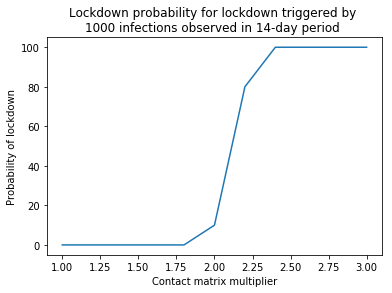

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(mults, [100 * l for l in avg_lockdowns])
plt.xlabel("Contact matrix multiplier")
plt.ylabel("Probability of lockdown")
plt.title("Lockdown probability for lockdown triggered by \n1000 infections observed in 14-day period ")

Text(0.5,1,'Average infections for lockdown triggered by \n1000 infections observed in 14-day period')

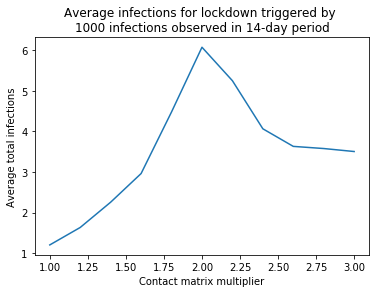

In [16]:
plt.plot(mults, avg_infections)
plt.xlabel("Contact matrix multiplier")
plt.ylabel("Average total infections")
plt.title("Average infections for lockdown triggered by \n1000 infections observed in 14-day period")

In [ ]:
lockdowns_by_mult = {}
infections_by_mult = {}
start = time.time()
for mult in [1,1.2,1.4,1.6,1.8,2, 2.2, 2.4, 2.6, 2.8, 3]:
    lockdowns, final_infections = simulate_lockdown(mult, 1000, 14)
    lockdowns_by_mult[mult] = lockdowns
    infections_by_mult[mult] = final_infections
    end = time.time()
    print("elapsed time on mult {} was {:.2f} seconds".format(mult, end-start))
    start = end

elapsed time on mult 1 was 73.00 seconds
elapsed time on mult 1.2 was 72.78 seconds


In [24]:
mults = []
avg_lockdowns = []
avg_infections = []

for mult in lockdowns_by_mult:
    mults.append(mult)
    avg_lockdowns.append(np.mean(lockdowns_by_mult[mult]))
    avg_infections.append(np.mean(infections_by_mult[mult]))

Text(0.5,1,'Lockdown probability for lockdown triggered by \n1000 infections observed in 7-day period ')

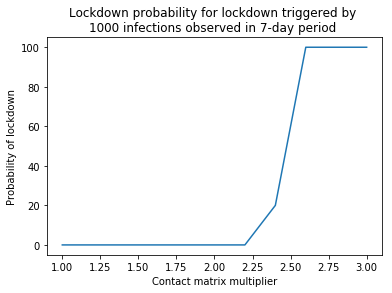

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(mults, [100 * l for l in avg_lockdowns])
plt.xlabel("Contact matrix multiplier")
plt.ylabel("Probability of lockdown")
plt.title("Lockdown probability for lockdown triggered by \n1000 infections observed in 7-day period ")

Text(0.5,1,'Lockdown probability for lockdown triggered by \n1000 infections observed in 7-day period')

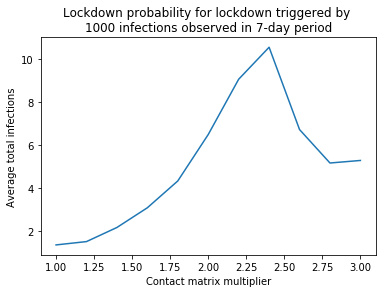

In [29]:
plt.plot(mults, avg_infections)
plt.xlabel("Contact matrix multiplier")
plt.ylabel("Average total infections")
plt.title("Lockdown probability for lockdown triggered by \n1000 infections observed in 7-day period")